In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import pytensor.tensor as pt
import arviz as az
import plotly.express as px

import scipy
from typing import Dict

/tmp/ipykernel_30208/102870125.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


The data can be loaded from the S3 bucket generated by the data-import pipeline or directly fetching from the rapid-api.
I have already the necessary data in my own S3 bucket so I copied it with the command `aws s3 cp s3://bayesball-raw-dev/fixtures/61/2022/data.csv data/`

For the demonstration purposes I will leave dataset used in this notebook to the Git repo so a interested user can follow along :)

In [2]:
df_fixtures = pd.read_csv("data/data.csv", sep=";", parse_dates=["game_date"])
df_fixtures.head()

,game_id,game_date,league_id,league_name,league_season,teams_home_id,teams_home_name,teams_away_id,teams_away_name,score_ht_home,score_ft_home,score_ht_away,score_ft_away
0,871470,2022-08-06 15:00:00+00:00,61,Ligue 1,2022,95,Strasbourg,91,Monaco,0.0,1.0,1.0,2.0
1,871471,2022-08-07 15:05:00+00:00,61,Ligue 1,2022,94,Rennes,97,Lorient,0.0,0.0,0.0,1.0
2,871472,2022-08-06 19:00:00+00:00,61,Ligue 1,2022,99,Clermont Foot,85,Paris Saint Germain,0.0,0.0,3.0,5.0
3,871473,2022-08-07 11:00:00+00:00,61,Ligue 1,2022,96,Toulouse,84,Nice,1.0,1.0,0.0,1.0
4,871474,2022-08-05 19:00:00+00:00,61,Ligue 1,2022,80,Lyon,98,Ajaccio,2.0,2.0,1.0,1.0


Some of the games are not played or they just have been cancelled and our database is not up to date. We can first inspect the matches that do not have have their home goals defined:

In [3]:
df_fixtures.query("score_ft_away.isna()")

,game_id,game_date,league_id,league_name,league_season,teams_home_id,teams_home_name,teams_away_id,teams_away_name,score_ht_home,score_ft_home,score_ht_away,score_ft_away
350,871820,2023-05-21 11:00:00+00:00,61,Ligue 1,2022,98,Ajaccio,94,Rennes,NaN,NaN,NaN,NaN
351,871821,2023-05-21 18:45:00+00:00,61,Ligue 1,2022,108,Auxerre,85,Paris Saint Germain,NaN,NaN,NaN,NaN
352,871822,2023-05-21 15:05:00+00:00,61,Ligue 1,2022,97,Lorient,116,Lens,NaN,NaN,NaN,NaN
353,871823,2023-05-20 15:00:00+00:00,61,Ligue 1,2022,83,Nantes,82,Montpellier,NaN,NaN,NaN,NaN
354,871824,2023-05-20 19:00:00+00:00,61,Ligue 1,2022,79,Lille,81,Marseille,NaN,NaN,NaN,NaN
355,871825,2023-05-21 13:00:00+00:00,61,Ligue 1,2022,84,Nice,96,Toulouse,NaN,NaN,NaN,NaN
357,871827,2023-05-21 13:00:00+00:00,61,Ligue 1,2022,106,Stade Brestois 29,99,Clermont Foot,NaN,NaN,NaN,NaN
358,871828,2023-05-21 13:00:00+00:00,61,Ligue 1,2022,93,Reims,77,Angers,NaN,NaN,NaN,NaN
359,871829,2023-05-21 13:00:00+00:00,61,Ligue 1,2022,110,Estac Troyes,95,Strasbourg,NaN,NaN,NaN,NaN
360,871830,2023-05-27 19:00:00+00:00,61,Ligue 1,2022,77,Angers,110,Estac Troyes,NaN,NaN,NaN,NaN


It appears that the games without scores are at the end of the season and we can drop those from our list.

In [4]:

df_fixtures = df_fixtures.dropna(subset="score_ft_home")

In our dataframe we have games played in the 2022-2023 season of France's league one.
Lets check out how many total teams the league has:

In [5]:
n_teams = df_fixtures["teams_home_id"].nunique()
n_teams

20

Usually there is an home team advantage in all sports games. Lets check out how many more goals teams playing in home field score compared to the away team:

In [6]:
print(f'Mean home team goals: {df_fixtures["score_ft_home"].mean():0.2f}, mean  away team goals: {df_fixtures["score_ft_away"].mean():0.2f}')
print(f'Home teams typically score: {(df_fixtures["score_ft_home"] - df_fixtures["score_ft_away"]).mean():0.2f} more goals')

Mean home team goals: 1.49, mean  away team goals: 1.30
Home teams typically score: 0.19 more goals


This is quite low home team advantage. One could calculate the statistical significance for this so we know whetever this is by random chance or there is actually a difference but we leave it at the interested reader.

We could also check how often the home teams win:

In [7]:
(
    df_fixtures
    .dropna()
    .assign(
        home_team_win = lambda x: x["score_ft_home"] > x["score_ft_away"],
        away_team_win = lambda x: x["score_ft_home"] < x["score_ft_away"],
        draw = lambda x: x["score_ft_home"] == x["score_ft_away"],
    )
    [["home_team_win", "draw", "away_team_win"]]
    .mean()
)

home_team_win    0.430199
draw             0.245014
away_team_win    0.324786
dtype: float64

It appears that home team won ~43% of their games, ~24.5% of the games ended up in draw and ~32% games were won by the away team.


We can plot the goal distribution of our games with the bar charts:

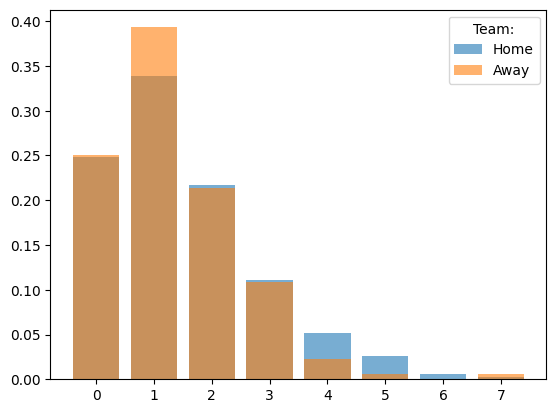

In [8]:
def get_goal_distribution(team: str) -> pd.DataFrame:
    return (
        df_fixtures
        .groupby(team)
        ["teams_home_id"]
        .describe()
        ["count"]
        .reset_index()
        .assign(count = lambda x: x["count"] / len(df_fixtures))
    )

home_goal_distribution = get_goal_distribution("score_ft_home")
away_goal_distribution = get_goal_distribution("score_ft_away")
plt.bar(home_goal_distribution["score_ft_home"], home_goal_distribution["count"], alpha=0.6, label="Home")
plt.bar(away_goal_distribution["score_ft_away"], away_goal_distribution["count"], alpha=0.6, label="Away")
plt.legend(title="Team:")

In this plot we can see that Away team end typically more games with 1 goal compared to the Home team but this does not reveal the true end scores. For example I can't see from this plot how many of the games ended with the score of 2-1. To do that we need to have 2d array with home goals in the x-axis and away goals in the y-axis.

Text(0, 0.5, 'Away Team Goals')

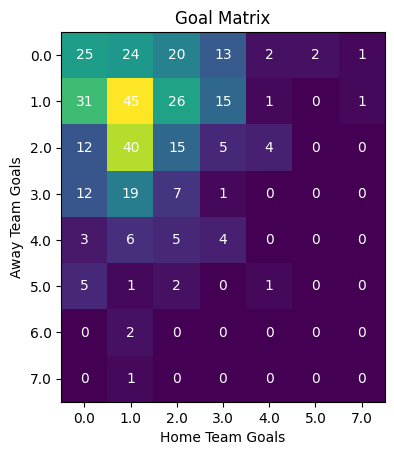

In [9]:
goal_matrix = (
    df_fixtures
    .groupby(["score_ft_home", "score_ft_away"])
    ["game_id"]
    .count()
    .reset_index()
    .rename({"game_id": "count"}, axis=1)
    .pivot_table(index="score_ft_home", columns="score_ft_away", values="count")
    .fillna(0)
    #.values
)
plt.imshow(goal_matrix)
plt.xticks(range(len(goal_matrix.columns)), goal_matrix.columns)
plt.yticks(range(len(goal_matrix.index)), goal_matrix.index)
for i in range(len(goal_matrix.index)):
    for j in range(len(goal_matrix.columns)):
        plt.text(j, i, str(int(goal_matrix.iloc[i, j])), ha='center', va='center', color='w')
plt.title("Goal Matrix")
plt.xlabel("Home Team Goals")
plt.ylabel("Away Team Goals")

Next let's define out model. The better model description is found at the repository README. First we have to change the teams so they are mapped from 0 to n_teams so the models understands it.

In [10]:
team_mappings_reverse = dict(enumerate(df_fixtures["teams_home_name"].unique()))
team_mappings = {v: k for k, v in team_mappings_reverse.items()}

first_50_games = (
    df_fixtures
    .sort_values("game_date")
    .iloc[0:50]
)

id_home = first_50_games["teams_home_name"].apply(lambda x: team_mappings[x])
id_away = first_50_games["teams_away_name"].apply(lambda x: team_mappings[x])
goals_home = first_50_games["score_ft_home"]
goals_away = first_50_games["score_ft_away"]

Next we define some starting parameters for the model:
Home_adv_mu defines our first guess at the home team advantage. We can leave it at zero
Similarly home_adv_std defines our uncertainty about the home team advantage. We can visualize our prior distribution of the home_adv distribution like so:

In [11]:
home_adv_mu = 0
home_adv_std = 0.4

Text(0.5, 1.0, 'How many more goals will the home team score on average')

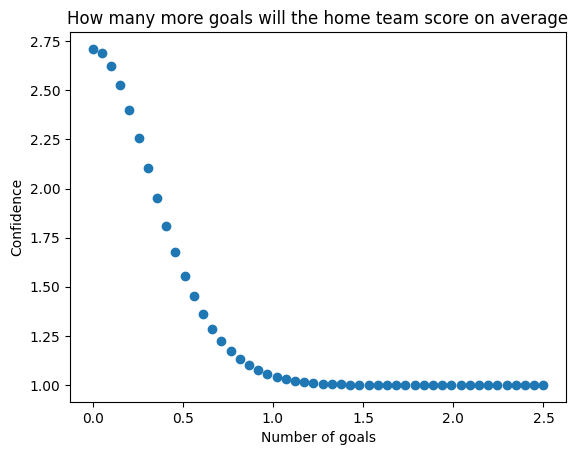

In [12]:
f = lambda x, mu, std:  np.exp(scipy.stats.norm.pdf(x, loc=mu, scale=std))
x = np.linspace(0, 2.5, 50)
y = f(x, mu=home_adv_mu, std=home_adv_std)
plt.scatter(x, y)
plt.xlabel("Number of goals")
plt.ylabel("Confidence")
plt.title("How many more goals will the home team score on average")

We can see that most of the probability mass is below one which reflects our values that we calculated before. For instance we could define our home_adv_mu as 0.5 with the std of 1 and we arrive at the following prior distribution:

Text(0.5, 1.0, 'How many more goals will the home team score on average')

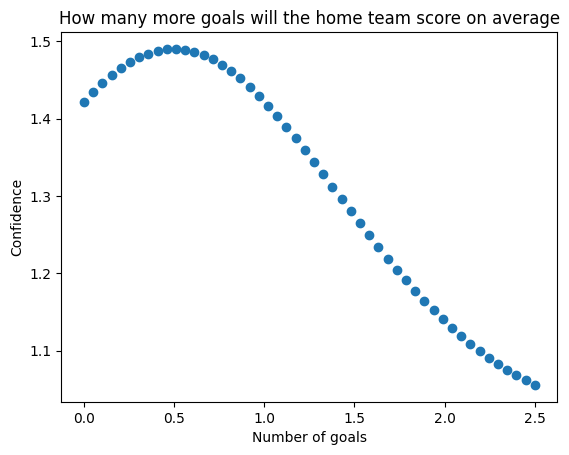

In [13]:
x = np.linspace(0, 2.5, 50)
y = f(x, mu=0.5, std=1)
plt.scatter(x, y)
plt.xlabel("Number of goals")
plt.ylabel("Confidence")
plt.title("How many more goals will the home team score on average")

This distribution is overly optimistic about the home team advantage and the first one is more credible. Anyways after running the model for some games the parameters we choose here don't matter as much. Lets define the rest of the parameters in the same fashion:  

In [14]:
intercept_mu = 0
intercept_std = 0.5
o_mu = np.zeros(n_teams)
d_mu = np.zeros(n_teams)
o_std = np.ones(n_teams)
d_std = np.ones(n_teams)
delta_sigma = 0.05

Now we can run the model from date for the first 50 days of the season:

In [15]:
#def run_model(home_adv_mu, home_adv_std, intercept_mu, intercept_std, o_mu, o_std, d_mu, d_std):
    # Note: it would be wise to define datamodel for the input as the input is growing quite big.
with pm.Model():
    # Global model parameters
    h = pm.Normal("home_adv", mu=home_adv_mu, sigma=home_adv_std)
    i = pm.Normal("intercept", mu=intercept_mu, sigma=intercept_std)

    # Team-specific poisson model parameters
    o_star_init = pm.Normal(
        "o_star_init", mu=o_mu, sigma=o_std, shape=n_teams
    )  # t-1 offence
    # Offence widening factor
    delta_o = pm.Normal("delta_o", mu=0.0, sigma=delta_sigma, shape=n_teams)
    o_star = pm.Deterministic("o_star", o_star_init + delta_o)  # Offence widened
    # Scaling it to relative value
    o = pm.Deterministic("o", o_star - pt.mean(o_star))

    d_star_init = pm.Normal(
        "d_star_init", mu=d_mu, sigma=d_std, shape=n_teams
    )  # t-1 defence
    # Defense widening factor
    delta_d = pm.Normal("delta_d", mu=0.0, sigma=delta_sigma, shape=n_teams)
    d_star = pm.Deterministic("d_star", d_star_init + delta_d)  # Defence widened
    d = pm.Deterministic("d", d_star - pt.mean(d_star))  # Scaling

    lambda_h = pt.exp(i + h + o[id_home] - d[id_away])
    lambda_a = pt.exp(i + o[id_away] - d[id_home])

    pm.Poisson("s_home", mu=lambda_h, observed=goals_home)
    pm.Poisson("s_away", mu=lambda_a, observed=goals_away)

    trace = pm.sample(
        5000,
        tune=2500,
        progressbar=True,
        return_inferencedata=True,
    )


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [home_adv, intercept, o_star_init, delta_o, d_star_init, delta_d]


Sampling 4 chains for 2_500 tune and 5_000 draw iterations (10_000 + 20_000 draws total) took 22 seconds.


We sampled 5000 samples from the posterior distributions but discarced the first 2500. The first 2500 samples are called "burn-in" (more resources at: http://users.stat.umn.edu/~geyer/mcmc/burn.html) and they might be located where the posterior values were improbable or otherwise not good. 

In pymc we receive a trace object which tells what posterior values the Markov chain Monte Carlo (MCMC) sampled. For example we can plot the posterior distributions for the intercept and home advantage parameters:

In [16]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'home_adv'}>,
        <Axes: title={'center': 'home_adv'}>]], dtype=object)

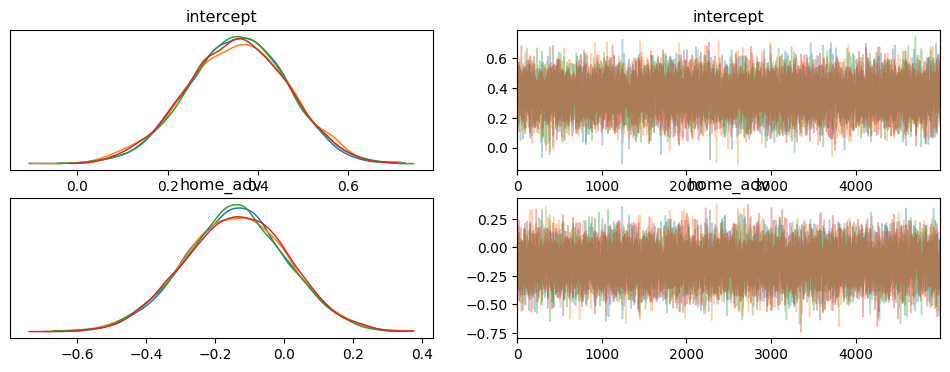

In [17]:
az.plot_trace(trace, var_names=["intercept", "home_adv"], compact=False)

Interestingly the home_advantage parameters mean seems to be below zero which means the home team actually has a disadvantage, although the posterior distribution is quite wide. We can for example calculate how certain the model is that the home team has disadvantage based on our priors and the first 50 games of the season:

In [18]:
(trace["posterior"]["home_adv"] < 0).mean().to_numpy()

array(0.82785)

Around 82% of the samples are below zero which means the model is quite somewhat certain that the home team has a disadvantage. I believe this is a pecularity of the early season or we just got a batch of games where we have some very strong teams playing on the away side. 

We can also plot the parameters of our teams similarly:

array([[<Axes: title={'center': 'o'}>, <Axes: title={'center': 'o'}>],
       [<Axes: title={'center': 'd'}>, <Axes: title={'center': 'd'}>]],
      dtype=object)

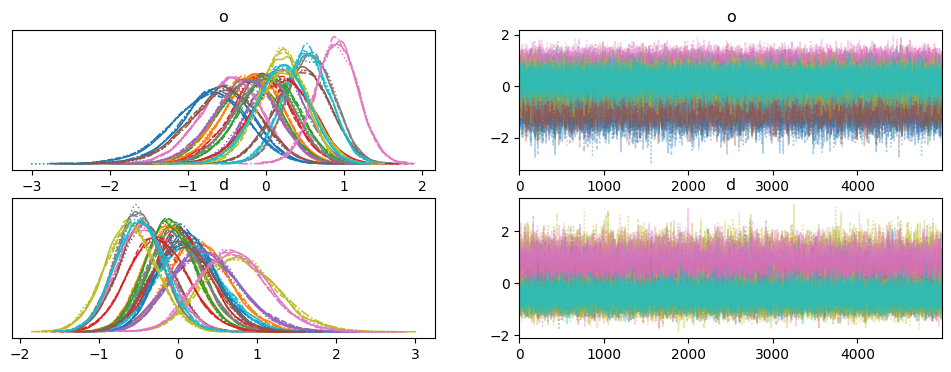

In [19]:
az.plot_trace(trace, var_names=["o", "d"])

We can clearly see that there are some teams which clearly dominate others. We can calculate the mean of the corresponding offensive and defensive distributions and plot those in a 2d graph to see the scores like we did with the goals

In [20]:
offensive_scores = trace["posterior"]["o"].mean(axis=(0, 1)).to_numpy()
defensive_scores = trace["posterior"]["d"].mean(axis=(0, 1)).to_numpy()
teams = list(team_mappings.keys())

# Create a DataFrame
df = (
    pd.DataFrame(
        {
            'Offensive Score': offensive_scores,
            'Defensive Score': defensive_scores,
            'Team': teams,
            'Team ID': list(team_mappings.values())
        }
    )
)

fig = px.scatter(
    df,
    x='Offensive Score',
    y='Defensive Score',
    text=df.apply(lambda row: f'{row["Team"]} ({row["Team ID"]})', axis=1),
    labels={'Offensive Score': 'Offensive score', 'Defensive Score': 'Defensive score'},
    title='Offensive and Defensive Values of Teams',
    width=800,
    height=800
)

fig.update_xaxes(range=[-1.2, 1.2])
fig.update_yaxes(range=[-1.2, 1.2])
fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    paper_bgcolor="LightSteelBlue",
)
fig.update_traces(textposition='top center')
# fig.update_layout(legend=dict(x=1.1, y=1.05))

fig.show()


We can see that Paris Saint Germain dominates the league according to our posteriors. This is good to see as I don't really follow football and it seems that they are on top of their league.

For example we can see that Marseille is great at defending against attacks but is a mediocre defender. We could for example calculate how probable it is for Nice to defeat Paris Saint Germain the following way:
1. First we calculate the mean posterior values

In [21]:
nice_o = trace["posterior"]["o"].mean(axis=(0, 1)).to_numpy()[15]
nice_d = trace["posterior"]["d"].mean(axis=(0, 1)).to_numpy()[15]

psg_o = trace["posterior"]["o"].mean(axis=(0, 1)).to_numpy()[16]
psg_d = trace["posterior"]["o"].mean(axis=(0, 1)).to_numpy()[16]

home_adv = trace["posterior"]["home_adv"].mean(axis=(0, 1)).to_numpy()
intercept = trace["posterior"]["intercept"].mean(axis=(0, 1)).to_numpy()

2. Calculate the marginal distributions and combine them into a joint distribution:

In [22]:
home_rate = np.exp(psg_o - nice_d + home_adv + intercept)
away_rate = np.exp(nice_o - psg_d + intercept)
goals = np.arange(0, 8)
home_goal_probabilities = scipy.stats.poisson.pmf(goals, mu=home_rate)
away_goal_probabilities = scipy.stats.poisson.pmf(goals, mu=away_rate)

joint_distribution = np.outer(home_goal_probabilities, away_goal_probabilities)
joint_distribution

array([[4.00728876e-02, 1.34762412e-02, 2.26598442e-03, 2.54011749e-04,
        2.13556085e-05, 1.43634936e-06, 8.05057637e-08, 3.86764917e-09],
       [1.15440454e-01, 3.88218444e-02, 6.52776194e-03, 7.31747406e-04,
        6.15204267e-05, 4.13778073e-06, 2.31917949e-07, 1.11417770e-08],
       [1.66278239e-01, 5.59182481e-02, 9.40246443e-03, 1.05399508e-03,
        8.86128553e-05, 5.95998086e-06, 3.34050213e-07, 1.60484041e-08],
       [1.59669347e-01, 5.36957223e-02, 9.02875424e-03, 1.01210301e-03,
        8.50908503e-05, 5.72309556e-06, 3.20773059e-07, 1.54105445e-08],
       [1.14992349e-01, 3.86711498e-02, 6.50242315e-03, 7.28906985e-04,
        6.12816231e-05, 4.12171913e-06, 2.31017714e-07, 1.10985280e-08],
       [6.62531192e-02, 2.22804762e-02, 3.74638677e-03, 4.19961516e-04,
        3.53075549e-05, 2.37473841e-06, 1.33101413e-07, 6.39444364e-09],
       [3.18099119e-02, 1.06974584e-02, 1.79874147e-03, 2.01634867e-04,
        1.69521107e-05, 1.14017605e-06, 6.39055832e-08, 3.

In [23]:
goal_matrix

score_ft_away,0.0,1.0,2.0,3.0,4.0,5.0,7.0
score_ft_home,,,,,,,
0.0,25.0,24.0,20.0,13.0,2.0,2.0,1.0
1.0,31.0,45.0,26.0,15.0,1.0,0.0,1.0
2.0,12.0,40.0,15.0,5.0,4.0,0.0,0.0
3.0,12.0,19.0,7.0,1.0,0.0,0.0,0.0
4.0,3.0,6.0,5.0,4.0,0.0,0.0,0.0
5.0,5.0,1.0,2.0,0.0,1.0,0.0,0.0
6.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


We can plot this joint distribution matrix to see the probability of each outcome of the match:

Text(0.5, 0, 'Nice Goals')

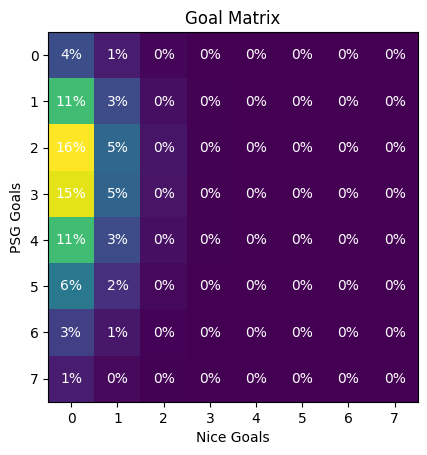

In [24]:
plt.imshow(joint_distribution)
for i in range(joint_distribution.shape[0]):
    for j in range(joint_distribution.shape[1]):
        plt.text(j, i, str(int(joint_distribution[i, j] * 100)) + "%", ha='center', va='center', color='w')
plt.title("Goal Matrix")
plt.ylabel("PSG Goals")
plt.xlabel("Nice Goals")

The probability of PSG winning the game is the lower triangular matrix, probability of Nice winning is the upper triangular matrix and probability of draw is the trace of our joint distribution matrix. 

In [25]:
nice_win = np.triu(joint_distribution, k=1).sum()
psg_win = np.tril(joint_distribution, k=-1).sum()
draw = np.trace(joint_distribution).sum()
print(f"Probability of Nice winning: {nice_win:0.2f}, PSG winning: {psg_win:0.2f} or the game ending up as draw: {draw:0.2f}")

Probability of Nice winning: 0.02, PSG winning: 0.88 or the game ending up as draw: 0.09


Not looking good for Nice

This was a simplified example of the model. In reality the model is run for every day meaning each iteration is sometimes only couple of matches. All of the posteriors are time series data where the offensive or defensive scores change as the model is run, just like the other parameters. A thorough reader might have spotted a parameter called delta_sigma. This parameter controls how much the scores change each day. Leaving it high, a bad streak plummets the team parameters faster, but is more prone to random fluctuations.


Why didn't I run the model like it should have been run? It takes quite a long time to run the model for a full season. I might create a second notebook where we explore the timeseries and how the parameters change each game day, but this is too much for this one notebook. If this type of modeling seemed interesting I recommend the reader to check out the documentation and examples at the PyMC gallery: https://www.pymc.io/projects/examples/en/latest/gallery.html 